<a href="https://colab.research.google.com/github/Sadreddini80/ML/blob/main/Finance_Classification_CVproject_V1_8_Sadreddini_4036170004_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/merged_features.csv /content/

In [ ]:
!unzip "/content/drive/MyDrive/Samples.zip" -d "/content/"

In [ ]:
!pip install opencv-python
!pip install xgboost
!pip install lightgbm

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# **1.three Sample Image from eache class**

['Inverse Single', 'Triple', 'Others', 'Inverse Double', 'Head AND Shoulder', 'Single', 'Inverse Triple', 'Inverse Head AND Shoulder', 'Double']
Class 'Inverse Single': 41250 images
Class 'Triple': 33181 images
Class 'Others': 97511 images
Class 'Inverse Double': 17964 images
Class 'Head AND Shoulder': 11380 images
Class 'Single': 41250 images
Class 'Inverse Triple': 32460 images
Class 'Inverse Head AND Shoulder': 11428 images
Class 'Double': 12734 images


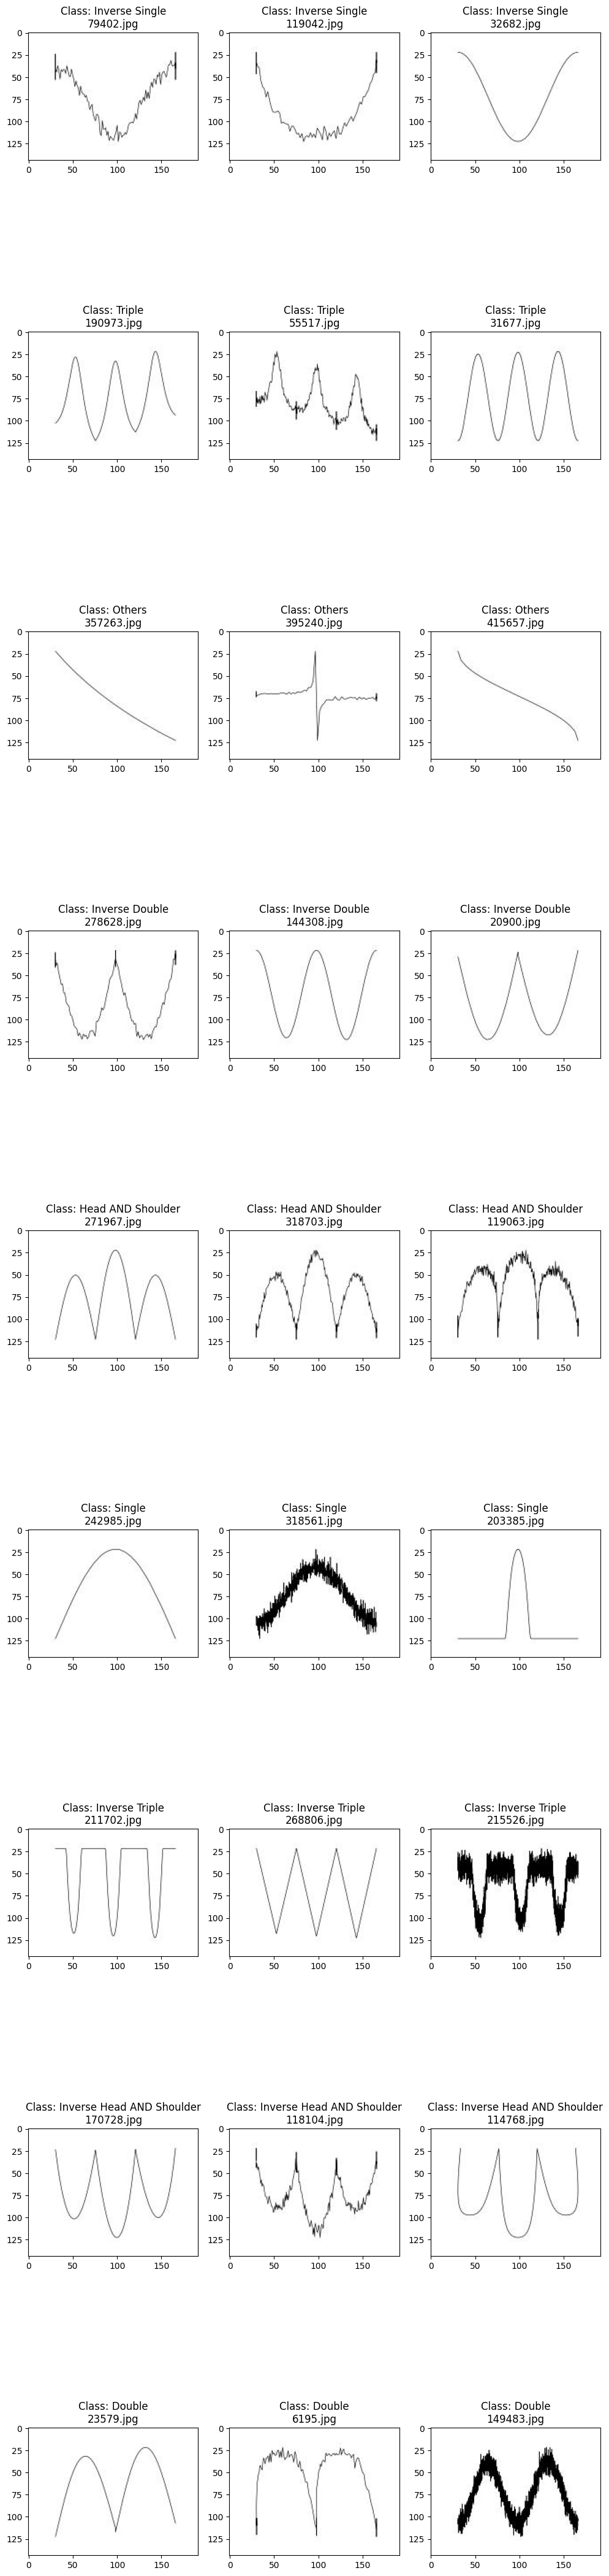

In [ ]:

# main folder
data_dir = "/content/Samples"

# recive class list
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

print(classes)
# count eache class picture
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    print(f"Class '{class_name}': {num_images} images")


num_samples = 3
#show
fig, axes = plt.subplots(len(classes), num_samples, figsize=(10, 5 * len(classes)))

for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg',))]
    sampled_images = random.sample(class_images, min(num_samples, len(class_images)))

    for j, img_path in enumerate(sampled_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax = axes[i, j] if len(classes) > 1 else axes[j]
        ax.imshow(image)
        ax.set_title(f'Class: {cls}\n{os.path.basename(img_path)}')
        ax.axis('on')

plt.tight_layout()
plt.show()

# **2. Load Dataset**

In [ ]:

DATASET_PATH = "/content/Samples"
CLASS_NAMES = os.listdir(DATASET_PATH)
IMG_SIZE = (128, 128)  # Standardized size

def load_images():
    X, y = [], []
    for class_label, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(DATASET_PATH, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            X.append(img)
            y.append(class_label)
    return np.array(X), np.array(y)

X, y = load_images()

## **3. Feature Extraction using ORB and AKAZE**

In [ ]:

def extract_features(images, method="ORB"):
    if method == "ORB":
        extractor = cv2.ORB_create(nfeatures=500)
    elif method == "AKAZE":
        extractor = cv2.AKAZE_create(threshold=0.00002,descriptor_size=64)

    descriptors_list = []
    for img in images:
        keypoints, descriptors = extractor.detectAndCompute(img, None)
        if descriptors is None:
            descriptors = np.zeros((1, 64))  # Handle empty descriptors for AKAZE
        descriptors_list.append(descriptors.flatten())
    return np.array(descriptors_list, dtype=object)

features_orb = extract_features(X, method="ORB")
features_akaze = extract_features(X, method="AKAZE")

# Ensure equal size for PCA processing
features_orb = np.array([f[:500] if len(f) >= 500 else np.pad(f, (0, 500 - len(f))) for f in features_orb])
features_akaze = np.array([f[:500] if len(f) >= 500 else np.pad(f, (0, 500 - len(f))) for f in features_akaze])

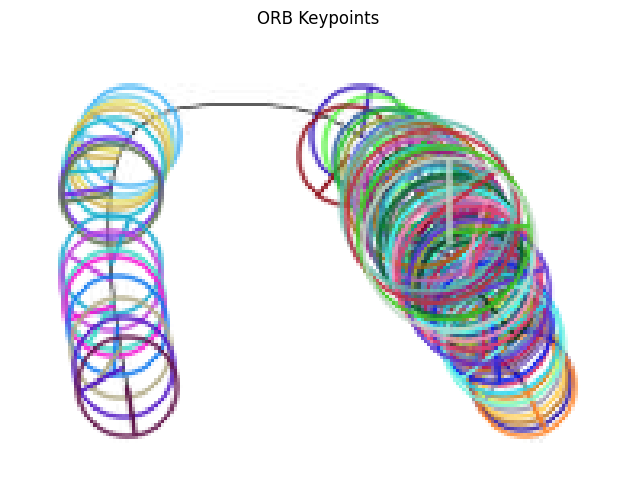

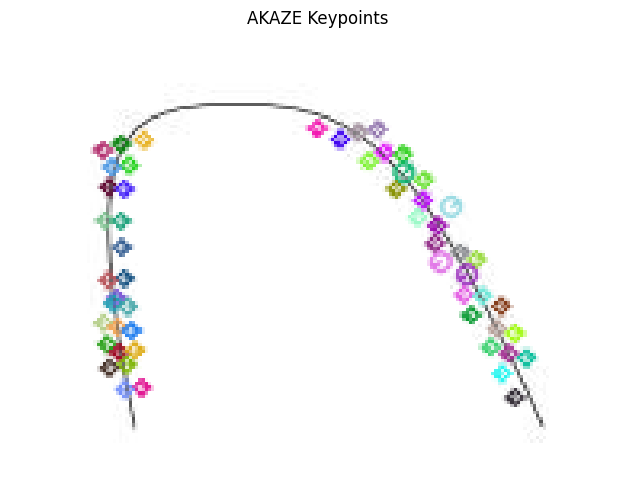

In [ ]:


def extract_and_plot_keypoints(image_path, detector_name):
    """Extract keypoints and descriptors using the specified detector and visualize them."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # Initialize detector
    if detector_name == "ORB":
        detector = cv2.ORB_create()
    elif detector_name == "AKAZE":
        detector = cv2.AKAZE_create(threshold=0.00002,descriptor_size=64)
    else:
        raise ValueError("Unsupported detector. Choose from ORB, SURF, AKAZE.")

    # Detect keypoints and compute descriptors
    keypoints, descriptors = detector.detectAndCompute(image, None)

    # Plot keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_keypoints, cmap='gray')
    plt.title(f"{detector_name} Keypoints")
    plt.axis("off")
    plt.show()

    return keypoints, descriptors

# Example usage
image_path = "/content/Samples/Single/1.jpg"
for detector in ["ORB", "AKAZE"]:
    extract_and_plot_keypoints(image_path, detector)


## 4. Dimensionality Reduction using ***PCA*** *italicized text*

In [ ]:
pca = PCA(n_components=100)
features_pca_orb = pca.fit_transform(features_orb)
features_pca_akaze = pca.fit_transform(features_akaze)
# ترکیب ویژگی‌های دو روش ORB و AKAZE
features_combined = np.hstack((features_pca_orb, features_pca_akaze))

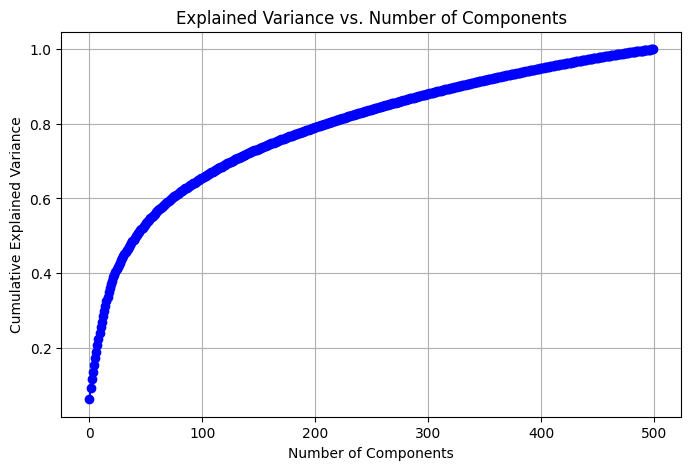

In [ ]:
# اجرای PCA برای محاسبه واریانس
pca_full = PCA().fit(features_orb)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

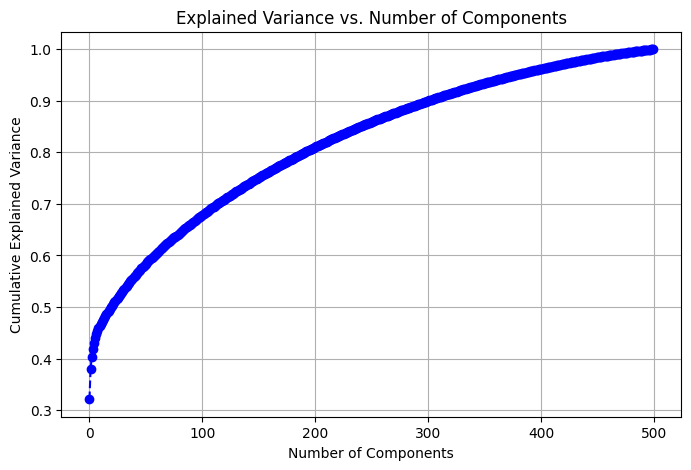

In [ ]:
# اجرای PCA برای محاسبه واریانس
pca_full = PCA().fit(features_akaze)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

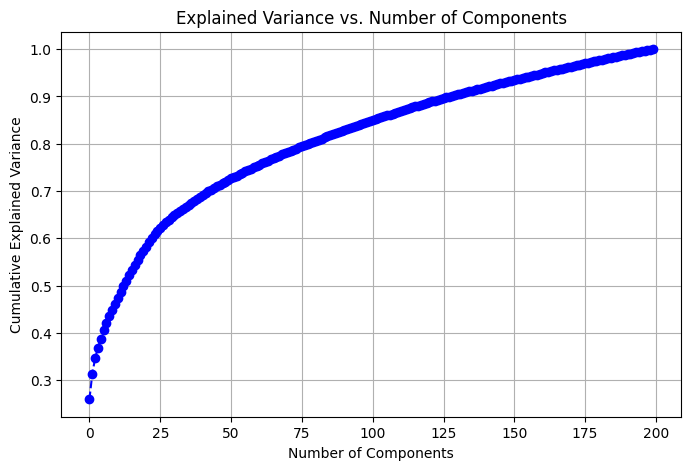

In [ ]:
# اجرای PCA برای محاسبه واریانس
pca_full = PCA().fit(features_combined)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

## 5. Train-Test **Split**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features_combined, y, test_size=0.2, random_state=42, stratify=y)

## 6.Model Training  **Check**

In [ ]:
performance = []

6.1 SVM

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8250
           1       0.94      0.95      0.94      6636
           2       0.97      0.98      0.98     19502
           3       0.98      0.98      0.98      3593
           4       0.93      0.92      0.92      2276
           5       0.96      0.94      0.95      8250
           6       0.90      0.93      0.92      6492
           7       0.88      0.77      0.82      2286
           8       0.97      0.95      0.96      2547

    accuracy                           0.95     59832
   macro avg       0.94      0.93      0.93     59832
weighted avg       0.95      0.95      0.95     59832



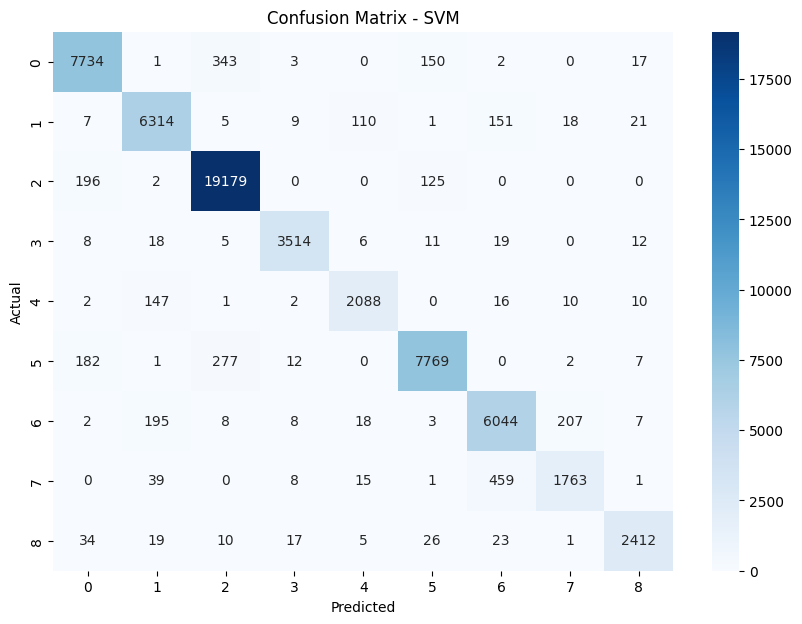

In [ ]:
# Model Training with Cross-Validation and Overfitting Check

models = {    "SVM": SVC()}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    performance.append([name, acc, precision, recall, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


6.2 XGBoost

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8250
           1       0.93      0.95      0.94      6636
           2       0.96      0.98      0.97     19502
           3       0.98      0.97      0.98      3593
           4       0.93      0.90      0.92      2276
           5       0.95      0.93      0.94      8250
           6       0.90      0.92      0.91      6492
           7       0.86      0.78      0.82      2286
           8       0.96      0.92      0.94      2547

    accuracy                           0.94     59832
   macro avg       0.93      0.92      0.93     59832
weighted avg       0.94      0.94      0.94     59832



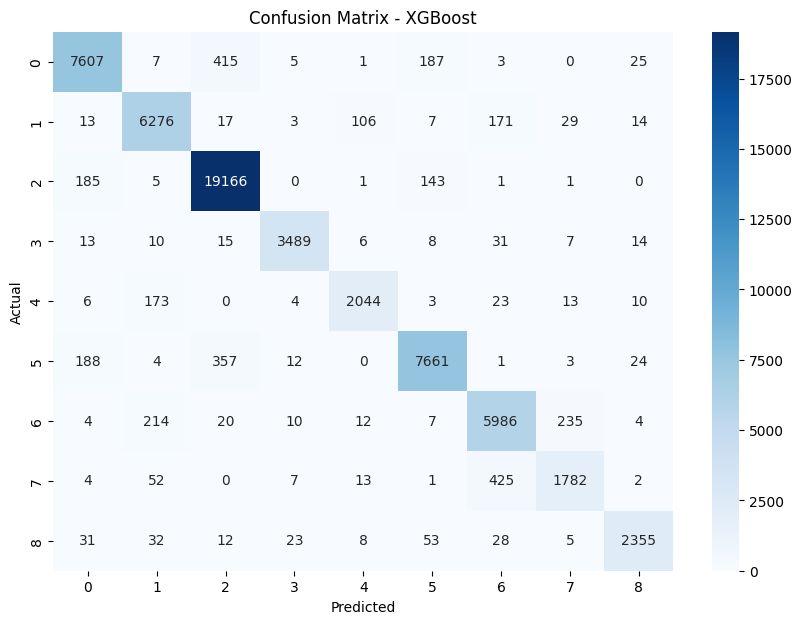

In [ ]:


models = {    "XGBoost": xgb.XGBClassifier(n_estimators=1200, learning_rate=0.1, max_depth=6)}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    performance.append([name, acc, precision, recall, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


6.3 KNN

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      8250
           1       0.88      0.91      0.89      6636
           2       0.91      0.98      0.94     19502
           3       0.97      0.95      0.96      3593
           4       0.96      0.85      0.90      2276
           5       0.91      0.85      0.88      8250
           6       0.81      0.92      0.86      6492
           7       0.83      0.64      0.72      2286
           8       0.95      0.80      0.86      2547

    accuracy                           0.90     59832
   macro avg       0.90      0.86      0.88     59832
weighted avg       0.90      0.90      0.90     59832



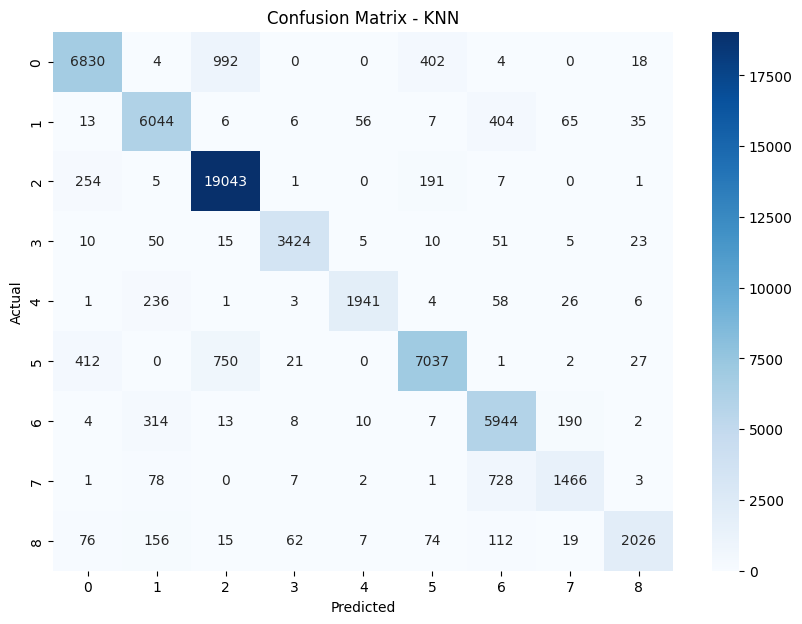

In [ ]:

models = {
    "KNN": KNeighborsClassifier(
        n_neighbors=8,  # Increase the number of neighbors to reduce sensitivity to noise
        weights='distance',  # Assign more weight to closer neighbors
        metric='euclidean'  # Use Euclidean distance for similarity measurement
    )
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    performance.append([name, acc, precision, recall, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()



6.4 RandomForest

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.59      0.72      8250
           1       0.69      0.89      0.78      6636
           2       0.76      1.00      0.86     19502
           3       0.94      0.87      0.90      3593
           4       0.96      0.44      0.61      2276
           5       0.88      0.67      0.76      8250
           6       0.72      0.81      0.76      6492
           7       1.00      0.26      0.42      2286
           8       0.91      0.62      0.74      2547

    accuracy                           0.79     59832
   macro avg       0.86      0.68      0.73     59832
weighted avg       0.82      0.79      0.78     59832



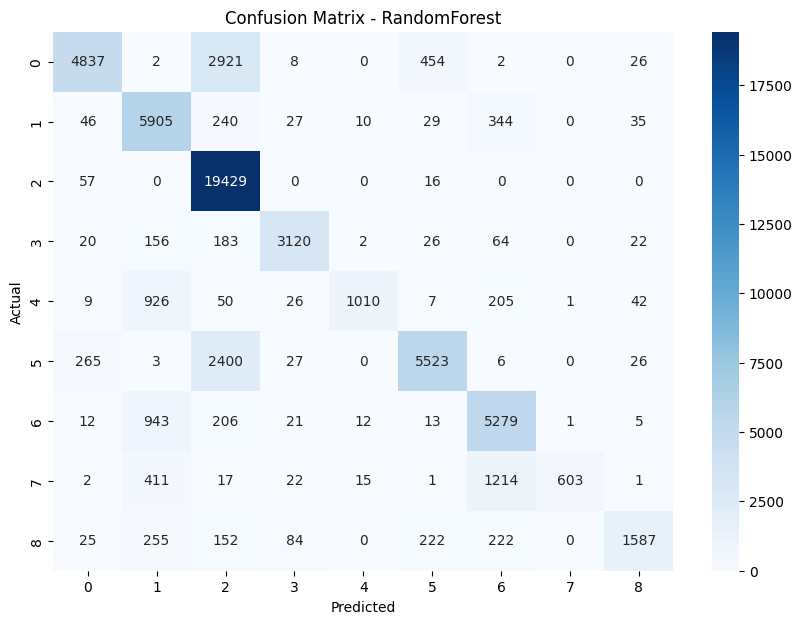

In [ ]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=1500,  # Number of trees in the forest
        max_depth=12,  # Maximum depth of each tree
        min_samples_split=10,  # Minimum number of samples required to split a node
        min_samples_leaf=5,  # Minimum number of samples required at each leaf node
        max_features='sqrt',  # Use the square root of the total features for best performance
        bootstrap=True,  # Enable bootstrap sampling
        random_state=42  # Ensure reproducibility
    )
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    performance.append([name, acc, precision, recall, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


6.5 DecisionTree

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      8250
           1       0.76      0.72      0.74      6636
           2       0.82      0.94      0.88     19502
           3       0.84      0.80      0.82      3593
           4       0.54      0.64      0.58      2276
           5       0.75      0.65      0.69      8250
           6       0.68      0.76      0.72      6492
           7       0.66      0.49      0.56      2286
           8       0.77      0.61      0.68      2547

    accuracy                           0.76     59832
   macro avg       0.72      0.69      0.70     59832
weighted avg       0.75      0.76      0.75     59832



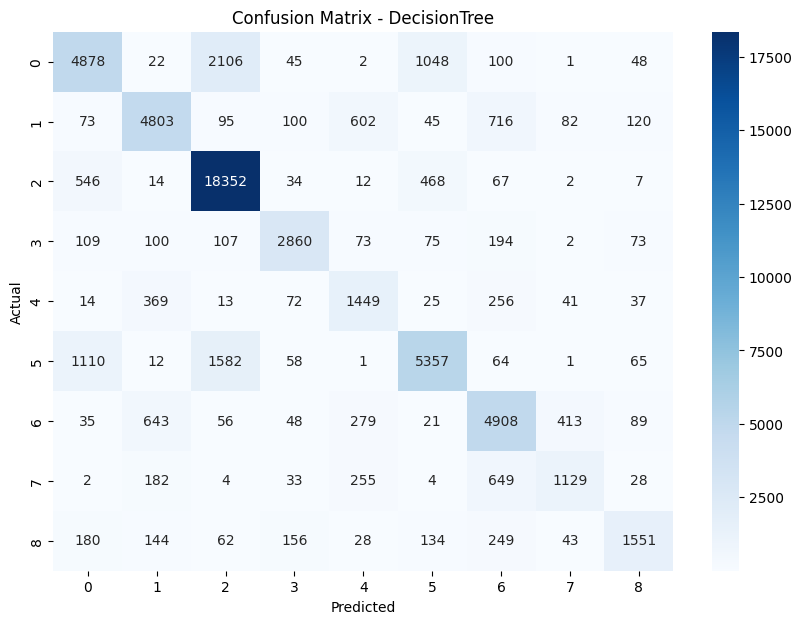

In [ ]:

models = {    "DecisionTree": DecisionTreeClassifier(max_depth=10)}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    performance.append([name, acc, precision, recall, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# 7 **Models** Performance

<ipython-input-21-d09164425bfd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=performance_df, palette="viridis")


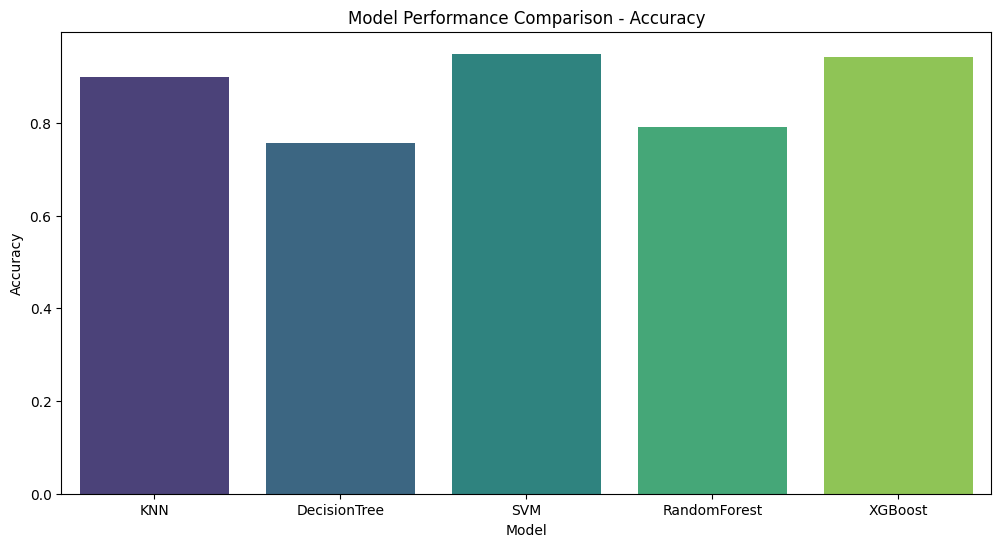

<Figure size 1200x600 with 0 Axes>

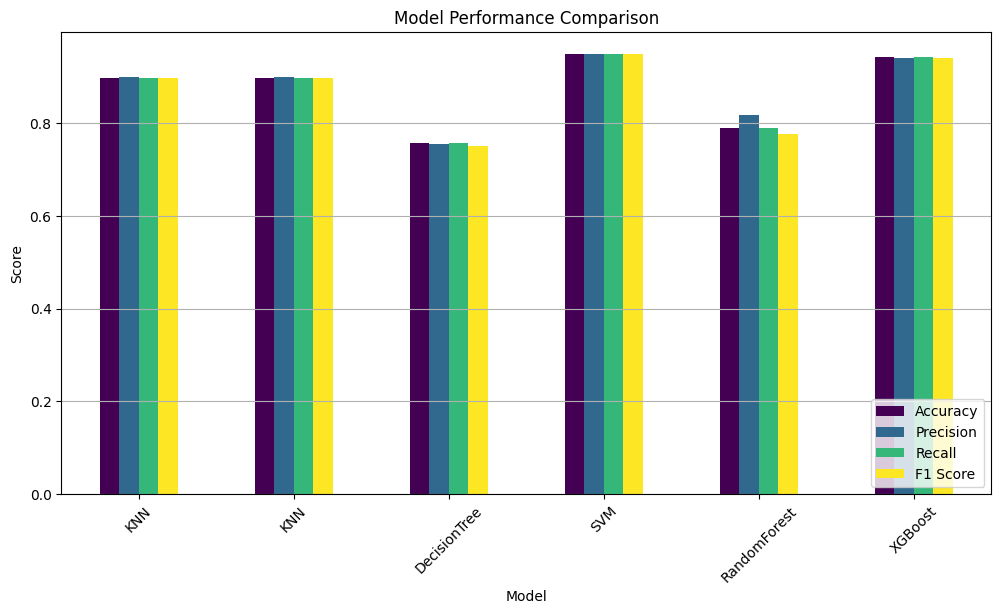

In [ ]:
# compare performance
performance_df = pd.DataFrame(performance, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=performance_df, palette="viridis")
plt.title("Model Performance Comparison - Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
performance_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()